# Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import TargetEncoder
from pycaret.regression import *

# Functions

In [2]:
def daily_resample(df):
    """Resample sales data to daily frequency per location and SKU."""
    return (
        df.groupby(['location', 'sku'])
          .resample('D')['quantity']
          .sum()
          .fillna(0)
          .reset_index()
    )

In [3]:
def create_features(df):
    """Extract calendar-based features from 'date' column."""
    df = df.copy()
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['day_of_week'] = df['date'].dt.dayofweek
    df['day_of_year'] = df['date'].dt.dayofyear
    df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)
    df['is_weekend'] = (df['day_of_week'].isin([5, 6])).astype(int)
    return df

In [4]:
def plot_sales(df, title="Sales Over Time"):
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x='date', y='quantity', alpha=0.7)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Data Preparation

In [5]:
base_path = os.path.abspath(os.path.join(".."))  
data_path = os.path.join(base_path, "data", "raw")

sales_file_path = os.path.join(data_path, "sales.csv")
daily_sales_df = pd.read_csv(sales_file_path, sep=';')

daily_sales_df.columns = daily_sales_df.columns.str.lower().str.replace(' ', '_')

daily_sales_df['sku'] = daily_sales_df['sku'].astype(str)

daily_sales_df = daily_sales_df.groupby(['date', 'location', 'sku'], as_index=False)['quantity'].sum()

daily_sales_df['date'] = pd.to_datetime(daily_sales_df['date'], format='%d/%m/%Y')

daily_sales_df.sort_values(by=['date', 'location', 'sku'], inplace=True)

## Exploratory Visualization

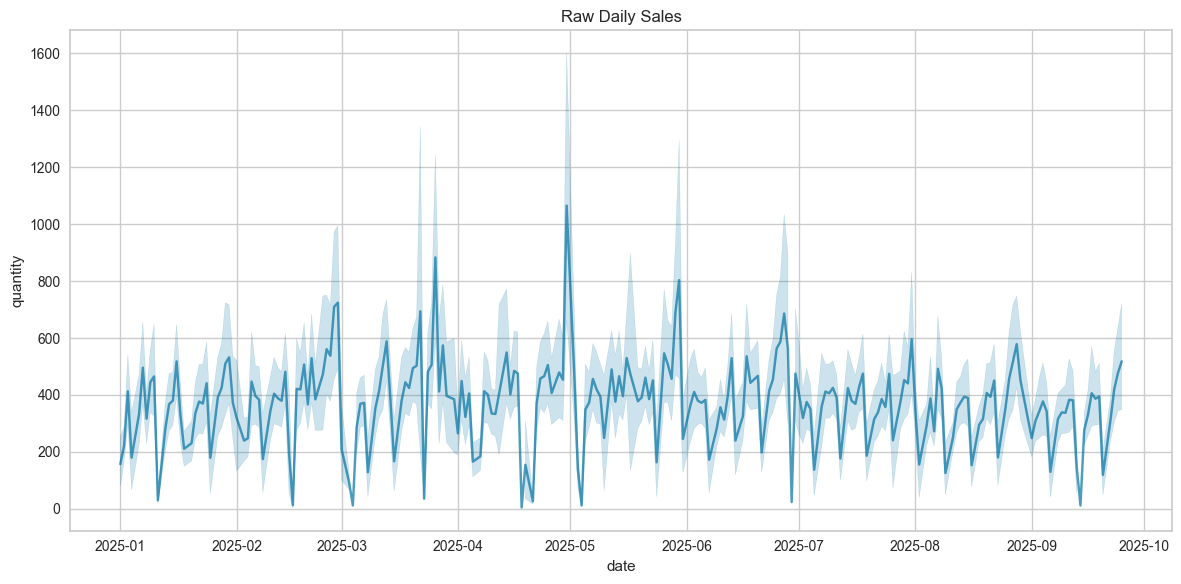

In [6]:
plot_sales(daily_sales_df, "Raw Daily Sales")

# Train Preparation

In [7]:
split_prediction_date = pd.to_datetime("2025-08-31")

train_df = daily_sales_df[daily_sales_df['date'] <= split_prediction_date].copy()

train_df.set_index('date', inplace=True)

train_df = daily_resample(train_df)

train_df = train_df[['date', 'location', 'sku', 'quantity']]

train_df.sort_values(by=['date', 'location', 'sku'], inplace=True)

## Exploratory Visualization

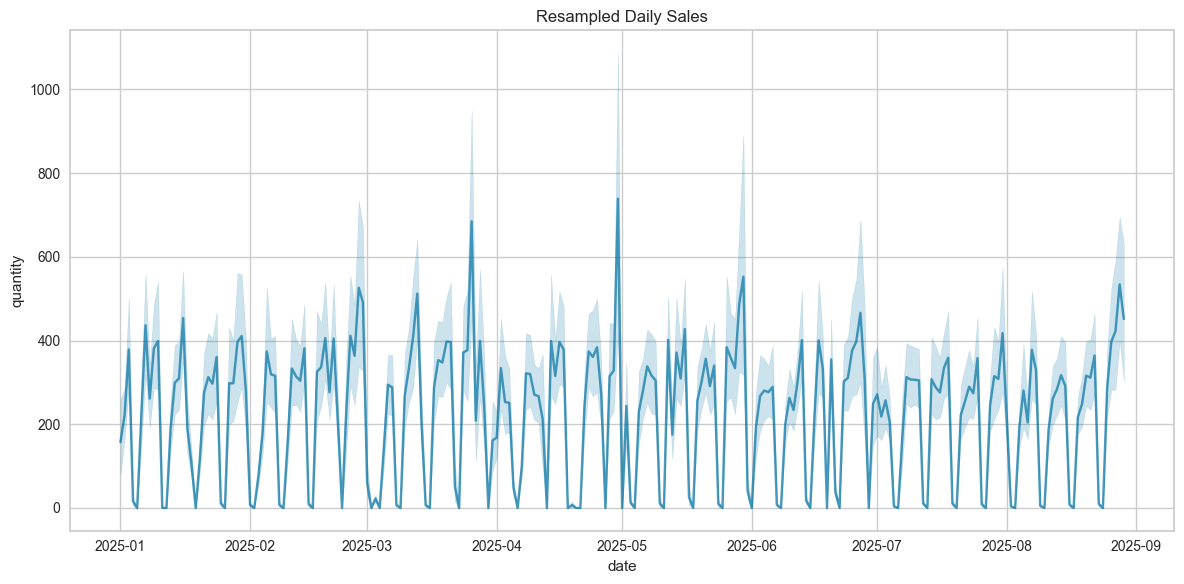

In [8]:
plot_sales(train_df, "Resampled Daily Sales")

## Feature Engineering

In [9]:
train_df = create_features(train_df)

## Encoding

In [10]:
encoder = TargetEncoder(cols=['location', 'sku'])
train_df[['location_encoded', 'sku_encoded']] = encoder.fit_transform(
    train_df[['location', 'sku']], train_df['quantity']
)

In [11]:
features_to_drop = ['location', 'sku', 'date']
train_df = train_df.drop(columns=features_to_drop)

# Automated Machine Learning

In [12]:
s = setup(
    train_df, 
    target='quantity', 
    session_id=123, 
    use_gpu=True,
    train_size=0.8
)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there a

,Description,Value
0,Session id,123
1,Target,quantity
2,Target type,Regression
3,Original data shape,"(206482, 10)"
4,Transformed data shape,"(206482, 10)"
5,Transformed train set shape,"(165185, 10)"
6,Transformed test set shape,"(41297, 10)"
7,Numeric features,9
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there a

In [13]:
#best = compare_models(include=['lr', 'ada', 'xgboost', 'lightgbm'])
best = compare_models(include=['lightgbm'])
final_model = finalize_model(best)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,159.7103,754561.7810,859.5781,0.5977,2.3467,2.4479,0.9000


# Best Model Application

In [14]:
forecast_df = daily_sales_df[daily_sales_df['date'] > split_prediction_date].copy()

In [15]:
forecast_df.set_index('date', inplace=True)
forecast_df = daily_resample(forecast_df)
forecast_df = create_features(forecast_df)

In [16]:
forecast_df[['location_encoded', 'sku_encoded']] = encoder.transform(forecast_df[['location', 'sku']])

forecast_features_to_drop = features_to_drop + ['quantity']
forecast_features = forecast_df.drop(columns=forecast_features_to_drop)

In [17]:
predictions = predict_model(final_model, data=forecast_features)

final_forecast_df = forecast_df.reset_index()[['date','location','sku','quantity']]
final_forecast_df['predicted_quantity'] = predictions['prediction_label'].values

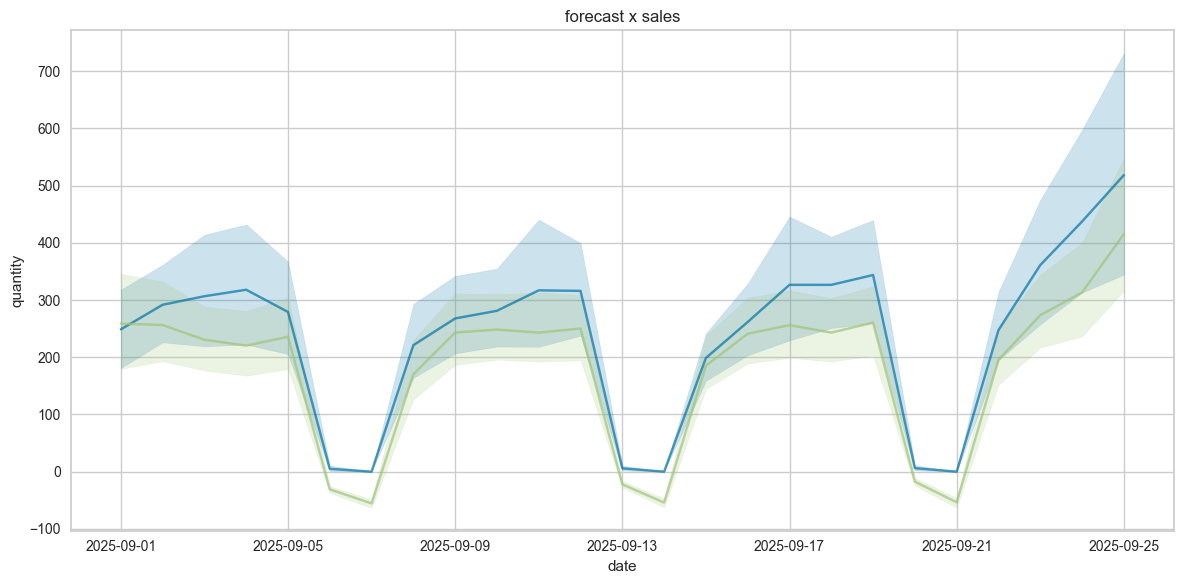

In [18]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=final_forecast_df, x='date', y='quantity', alpha=0.7)
sns.lineplot(data=final_forecast_df, x='date', y='predicted_quantity', alpha=0.7)
plt.title('forecast x sales')
plt.tight_layout()
plt.show()

In [19]:
sku_file_path = os.path.join(data_path, "sku_data.csv")
sku_df = pd.read_csv(sku_file_path, sep=';')
sku_df.dropna(inplace=True)
sku_df['SKU'] = sku_df['SKU'].astype(str)
sku_df['SKU'] = sku_df['SKU'].str.split('.').str[0]
sku_df.columns = sku_df.columns.str.lower().str.replace(' ', '_')
sku_df = sku_df[['sku', 'material']] 

location_file_path = os.path.join(data_path, "location_data.csv")
location_df = pd.read_csv(location_file_path, sep=';')
location_df.columns = location_df.columns.str.lower().str.replace(' ', '_')
location_df = location_df[['location', 'warehouse']]

In [20]:
final_forecast_df = final_forecast_df.merge(sku_df, on='sku', how='left')
final_forecast_df = final_forecast_df.merge(location_df, on='location', how='left')

In [21]:
final_forecast_df.head()

,date,location,sku,quantity,predicted_quantity,material,warehouse
0,2025-09-01,ASDF,1004996,128,8.275887,Hyundai HB20,Florianópolis
1,2025-09-02,ASDF,1004996,32,14.558842,Hyundai HB20,Florianópolis
2,2025-09-03,ASDF,1004996,24,19.358705,Hyundai HB20,Florianópolis
3,2025-09-04,ASDF,1004996,472,19.358705,Hyundai HB20,Florianópolis
4,2025-09-05,ASDF,1004996,56,25.581096,Hyundai HB20,Florianópolis
